/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.8102467060089111
step 2: elapsed 0.01594257354736328
step 3: elapsed 0.02048182487487793
step 4: elapsed 0.3160066604614258
step 5: elapsed 0.0044062137603759766
step 5: elapsed 0.002957582473754883
elapsed 1.1719779968261719
#Humans 2


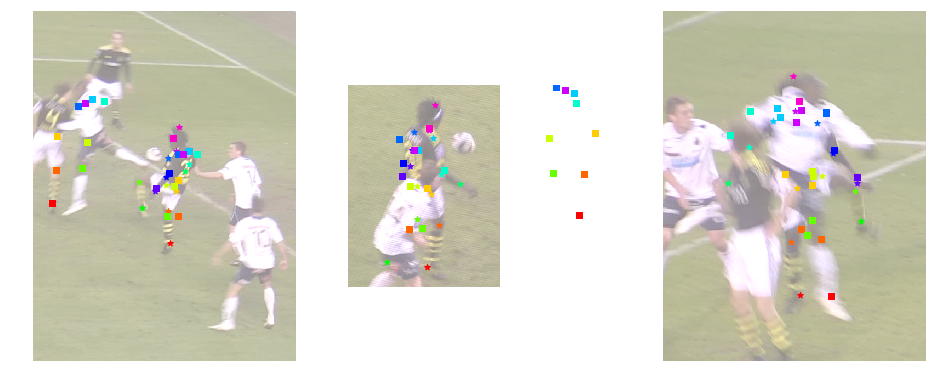

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000)

colors = cs.lincolor(16).astype('float32')/255
FRAME = 85 # 85
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
# seq1_zipname = 'player2sequence1.zip'
# seq1_dir = 'Sequence 1'
player = 1
Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, FRAME, player=player)


from mvpose.algorithm.candidate_selection import project_human_to_2d

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME, dir='/home/julian/Temp')
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = kth.transform3d_from_mscoco(detections)
print('#Humans', len(Humans))

fig = plt.figure(figsize=(16,10))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid], marker='*')

    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, Calib[cid])
        for jid, p in enumerate(human2d):
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[jid], marker='s')

plt.show()

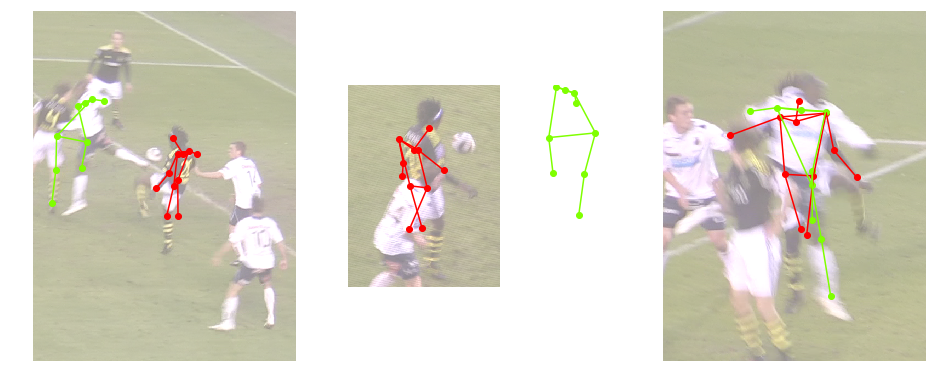

In [2]:
fig = plt.figure(figsize=(16,10))

colors = cs.lincolor(5).astype('float32')/255

for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for pid, human in enumerate(Humans):
        kth.draw_limbs2d(ax, human, Calib[cid], color=colors[pid], print_length=False)
        
plt.show()

In [ ]:
from mvpose.evaluation import pcp
import mvpose.data.skeleton_augmentation as ska

model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)
use_heuristic = False

larms = []
uarms = []
llegs = []
ulegs = []
pelvis = []
shoulder = []
head = []
all_parts = []

larms_ex = []
uarms_ex = []
llegs_ex = []
ulegs_ex = []
pelvis_ex = []
shoulder_ex = []
head_ex = []
all_parts_ex = []

def extract_best(pos3d, Humans):
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    pelvis = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
            pelvis = r.pelvis
            all_parts = r.all_parts
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs,
        "pelvis": pelvis,
        "all_parts": all_parts
    }
    

for frame in range(0, 170, 5):
    _start = time()
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=player)
    heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir='/home/julian/Temp')
    
    if use_heuristic:
        detections = pose.estimate_heuristic(
            Calib, heatmaps, pafs, settings=params)
    else:
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params)
    
#     if add_missing_limbs:
#         detections = gen.apply(detections)
    alpha = 0.5
    
    # ~~~~~ no adding of limbs ~~~~~
    Humans = kth.transform3d_from_mscoco(detections)
    result = extract_best(pos3d, Humans)
    larms.append(result['larms'])
    uarms.append(result['uarms'])
    llegs.append(result['llegs'])
    ulegs.append(result['ulegs'])
    pelvis.append(result['pelvis'])
    all_parts.append(result['all_parts'])
    
    # ~~~~~~ adding limbs if needed ~~~~~~
    detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    result = extract_best(pos3d, Humans)
    larms_ex.append(result['larms'])
    uarms_ex.append(result['uarms'])
    llegs_ex.append(result['llegs'])
    ulegs_ex.append(result['ulegs'])
    pelvis_ex.append(result['pelvis'])
    all_parts_ex.append(result['all_parts'])

    
    del Humans
    del detections
    
    _end = time()
    print('frame ' + str(frame) + ', elapsed', _end - _start)

frame 0, elapsed 4.449406862258911
frame 5, elapsed 4.28558087348938
frame 10, elapsed 4.500092506408691
frame 15, elapsed 4.800678253173828
frame 20, elapsed 4.737104892730713
frame 25, elapsed 4.705380916595459
frame 30, elapsed 4.823125839233398
frame 35, elapsed 4.833028078079224
frame 40, elapsed 5.044061899185181
frame 45, elapsed 5.163772821426392
frame 50, elapsed 5.145212173461914
frame 55, elapsed 5.588232517242432
frame 60, elapsed 5.318238735198975
frame 65, elapsed 5.324764966964722
frame 70, elapsed 5.939296722412109
frame 75, elapsed 5.712339639663696
frame 80, elapsed 5.91902494430542
frame 85, elapsed 6.515219449996948
frame 90, elapsed 6.272403717041016
frame 95, elapsed 7.098025798797607


In [ ]:
print('+++ No limb heuristic +++')
print('lower arms:\t', np.mean(larms))
print('upper arms:\t', np.mean(uarms))
print('lower legs:\t', np.mean(llegs))
print('upper legs:\t', np.mean(ulegs))
print('pelvis:\t\t', np.mean(pelvis))
print('shoulder:\t', np.mean(shoulder))
print('head:\t\t', np.mean(head))
print('all parts:\t', np.mean(all_parts))

print('+++ With limb heuristic +++')
print('lower arms:\t', np.mean(larms_ex))
print('upper arms:\t', np.mean(uarms_ex))
print('lower legs:\t', np.mean(llegs_ex))
print('upper legs:\t', np.mean(ulegs_ex))
print('pelvis:\t\t', np.mean(pelvis_ex))
print('shoulder:\t', np.mean(shoulder_ex))
print('head:\t\t', np.mean(head_ex))
print('all parts:\t', np.mean(all_parts_ex))

In [ ]:
plt.plot(range(len(llegs)), llegs)